In [1]:
import shapefile
import zipfile
import shapely
import pyproj
import pandas as pd
from shapely.geometry import LineString
import osmnx as ox
import geopandas as gpd
from numpy.linalg import norm
import numpy as np
import math
from matplotlib import pyplot as plt
import contextily as cx
from pyproj.crs import CRS
import scipy
from datetime import timedelta

from shapely.ops import linemerge

import route2vel
import route2vel.utils as utils
from route2vel.loading import load_graph
from route2vel.route import find_route
import route2vel
from notebookutils import *

from route2vel.interp import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
plt.style.use('dark_background')

Interpolate a single polyline obtained from a route, while trying to identify route parts.

In [4]:
graph_area = "Città Metropolitana di Bologna"

In [5]:
route2vel.load_config("../..")

In [6]:
graph = load_graph(graph_area)
graph_gdf_nodes, graph_gdf_edges = ox.graph_to_gdfs(graph)

Loading graph from D:\Documenti\Universita\tesim\resources\graph\Città Metropolitana di Bologna.graphnx.pickle ...
Loaded in 1.04s!


Make sure to run the script in the root directory to start the local OSRM container.

In [7]:
import routingpy

router_osrm = routingpy.OSRM(base_url='http://localhost:5000')

In [8]:
route_steps = ["Ospedale Maggiore, Bologna", "Porta Santo Stefano, Bologna", "Bologna Fiere, Bologna"]
route_coords = [ox.geocode(loc)[::-1] for loc in route_steps]

In [9]:
osrm_route = router_osrm.directions(route_coords, profile='car', annotations=True)
print(f"Route has {len(osrm_route.geometry)} positions, duration: {timedelta(seconds=osrm_route.duration)}, distance: {osrm_route.distance / 1000:.2f}km")

Route has 26 positions, duration: 0:19:10, distance: 11.10km


In [10]:
node_ids = []
for route_leg in osrm_route._raw['routes'][0]['legs']:
    node_ids.extend([int(id) for id in route_leg['annotation']['nodes']])

In [11]:
graph = load_graph("Città Metropolitana di Bologna")

Loading graph from D:\Documenti\Universita\tesim\resources\graph\Città Metropolitana di Bologna.graphnx.pickle ...
Loaded in 0.92s!


In [12]:
print(f"Amount of nodes in path: {len(node_ids)}")
print("(Includes nodes used only for geometry and stripped from osmnx graphs)")

node_ids_simple = list(filter(lambda id: id in graph.nodes, node_ids))

print(f"Nodes after simplification: {len(node_ids_simple)}")

Amount of nodes in path: 392
(Includes nodes used only for geometry and stripped from osmnx graphs)
Nodes after simplification: 97


In [13]:
route_gdf = ox.utils_graph.route_to_gdf(graph, node_ids_simple, "travel_time")

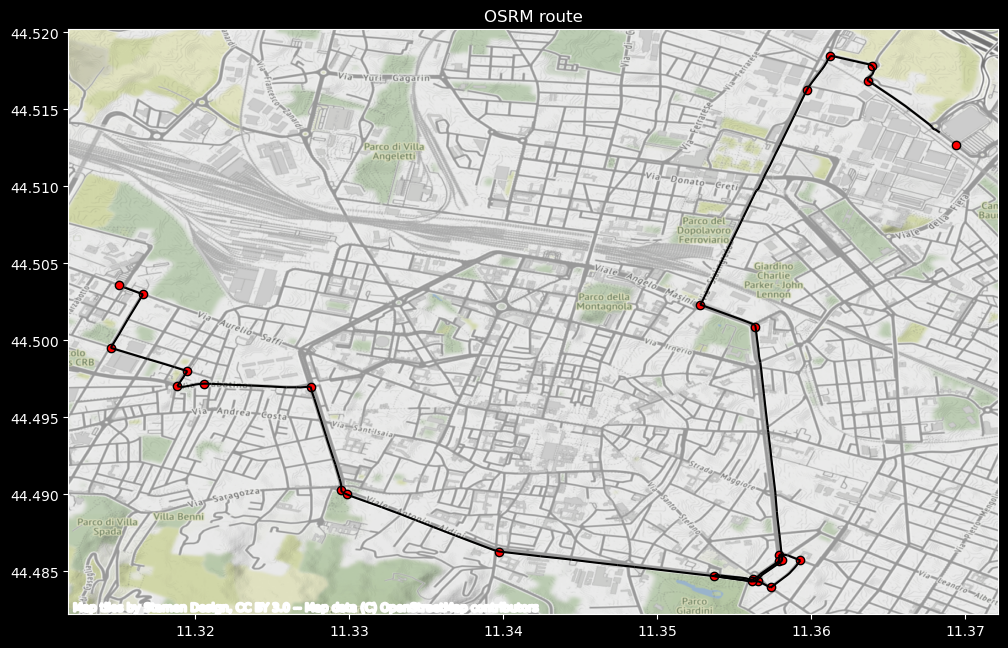

In [14]:
crs = 'epsg:4326'
osrm_points_gdf = gpd.GeoDataFrame({'geometry': [Point(x) for x in osrm_route.geometry]}, crs=crs)
fig, ax = plt.subplots(figsize=(12, 12))
route_gdf.plot(ax=ax, color='k')
osrm_points_gdf.plot(ax = ax, color='r', edgecolor='k')
cx.add_basemap(ax, crs=crs)
plt.title("OSRM route");

In [15]:
split_route_gdf = split_route_gdf_by_curves(route_gdf, 15)

In [16]:
print(f"Original route gdf length: {len(route_gdf)}")
print(f"After splitting into curves: {len(split_route_gdf)}")

Original route gdf length: 96
After splitting into curves: 193


In [17]:
pts, pt_labels = get_point_in_route_gdf(split_route_gdf, np.linspace(0, 1, num=2000*len(route_gdf)), return_label=True)

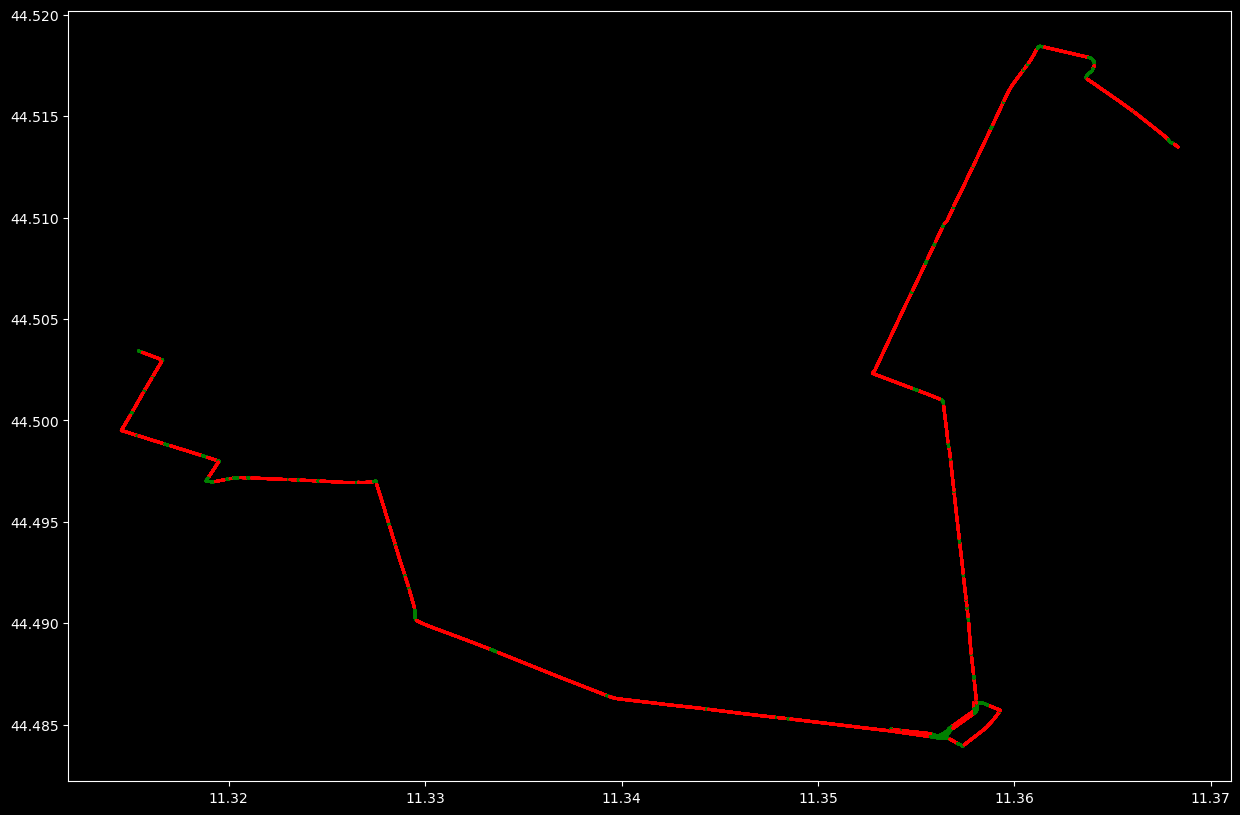

In [18]:
pts_x = pts.transpose()[0]
pts_y = pts.transpose()[1]

fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(pts_x, pts_y, s=1, color = ['g' if l else 'r' for l in pt_labels])
plt.show()

In [19]:
# route_interp_gdf = gpd.GeoDataFrame({
#     'geometry': [LineString([pt, next_pt]) for pt, next_pt in zip(pts[:-1], pts[1:])],
#     'curve': ['curve' if l else 'straight' for l in pt_labels[:-1]],
# }, geometry='geometry', crs=route_gdf.crs)
points_interp_gdf = gpd.GeoDataFrame({
    'geometry': [Point(pt) for pt in pts],
    'curve': ['curve' if l else 'straight' for l in pt_labels],
}, geometry='geometry', crs=route_gdf.crs)

c:\Users\fillo\anaconda3\envs\ox\Lib\site-packages\contextily\tile.py:581: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


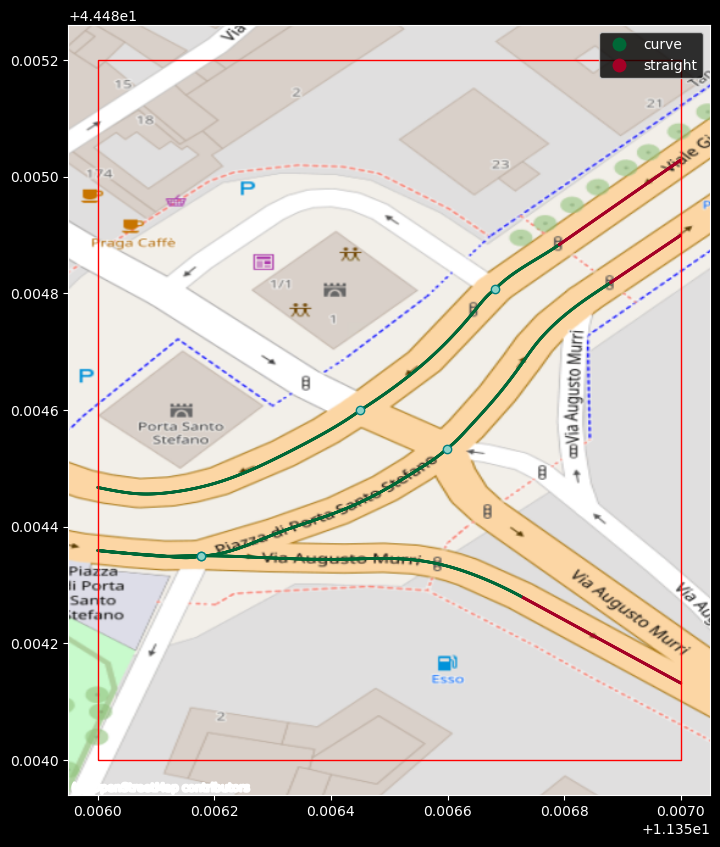

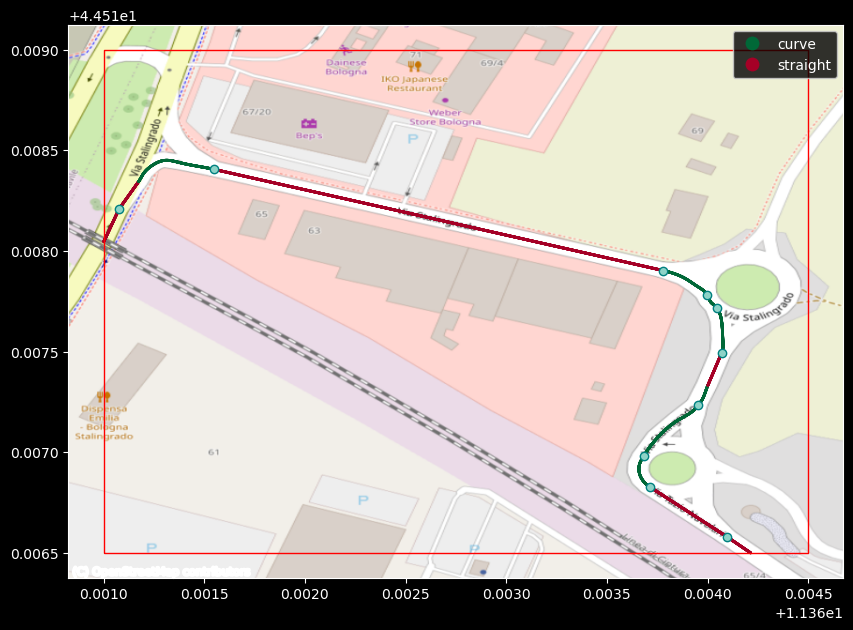

c:\Users\fillo\anaconda3\envs\ox\Lib\site-packages\contextily\tile.py:581: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


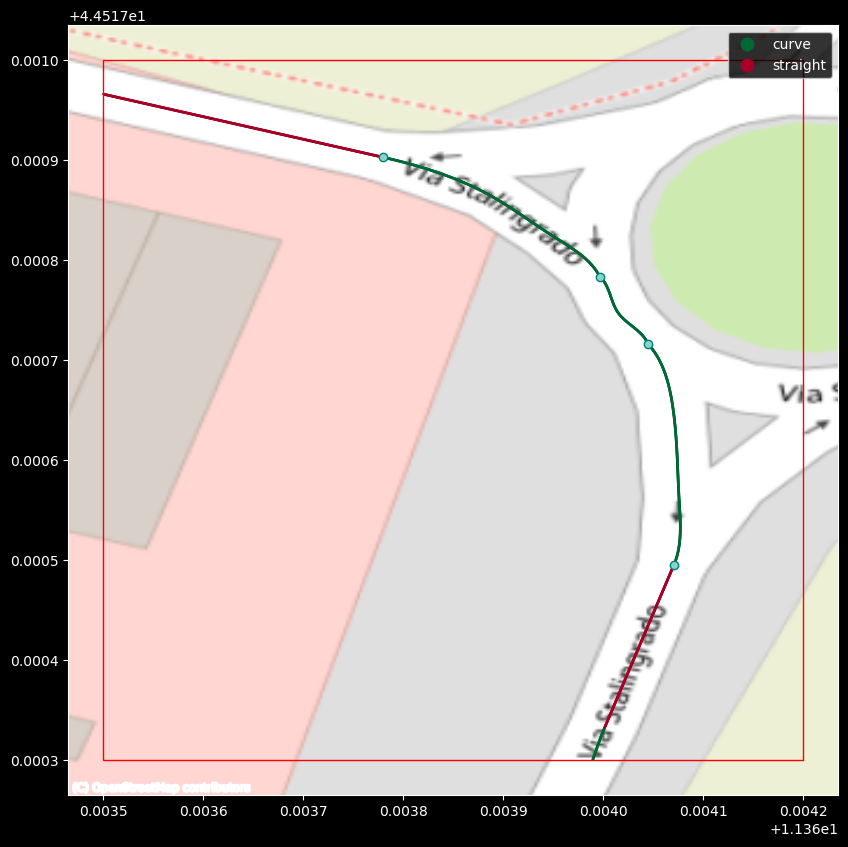

In [20]:
interesting_bound_set = [
    ((11.356, 44.484), (11.357, 44.4852)),
    ((11.361, 44.5165), (11.3645, 44.519)),
    ((11.3635, 44.5173), (11.3642, 44.5180)),
]

node_positions = [Point(graph.nodes[id]["x"], graph.nodes[id]["y"]) for id in node_ids_simple]

for bounds in interesting_bound_set:
    display_bounded_shapes([
        # (route_interp_gdf, {'column': 'curve', 'categorical':True, 'legend':True, 'cmap':'RdYlGn_r'}),
        (points_interp_gdf, {'column': 'curve', 'categorical':True, 'legend':True, 'cmap':'RdYlGn_r', 's': 1}),
        (GeoDataFrame({"geometry": node_positions}, geometry="geometry"), {}),
    ], *bounds, crs=route_gdf.crs);